### Footbal predictions
The following Notebook shows the process of developing a model that predicts match outcomes for matches of UEFA teams.

In [97]:
import pandas as pd
import numpy as np

results = pd.read_csv("results.csv")

In [99]:
results

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
...,...,...,...,...,...,...,...,...,...
47912,2024-11-19,Oman,Iraq,0,1,FIFA World Cup qualification,Muscat,Oman,False
47913,2024-11-19,Kuwait,Jordan,1,1,FIFA World Cup qualification,Kuwait City,Kuwait,False
47914,2024-11-19,Bahrain,Australia,2,2,FIFA World Cup qualification,Riffa,Bahrain,False
47915,2024-11-19,Indonesia,Saudi Arabia,2,0,FIFA World Cup qualification,Jakarta,Indonesia,False


In [101]:
import pandas as pd
import numpy as np

df = pd.read_csv('results.csv')

# Filter for European countries
european_countries = [
    'Albania', 'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 
    'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 
    'Denmark', 'Estonia','England', 'Finland', 'France', 'Faroe Islands', 'Georgia', 'Germany', 'Greece', 'Hungary', 
    'Iceland', 'Republic of Ireland', 'Italy', 'Israel', 'Kazakhstan', 'Kosovo', 'Latvia', 'Liechtenstein', 
    'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 
    'North Macedonia', 'Norway', 'Northern Ireland', 'Poland', 'Portugal', 'Romania', 'Russia', 
    'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Scotland', 
    'Turkey', 'Ukraine', 'Gibraltar', 'Wales'
]
print(len(european_countries))
df = df[df['home_team'].isin(european_countries) & df['away_team'].isin(european_countries)]

df['home_advantage'] = np.where(df['neutral'] == False, 1, 0)

# Encode match outcome
# 0 = Draw, 1 = Home Win, 2 = Away Win
df['match_outcome'] = df.apply(
    lambda row: 1 if row['home_score'] > row['away_score'] else
                (2 if row['home_score'] < row['away_score'] else 0), axis=1)
df

55


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_advantage,match_outcome
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,1,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,1,1
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,1,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,1,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...
47886,2024-11-19,Montenegro,Turkey,3,1,UEFA Nations League,Podgorica,Montenegro,False,1,1
47887,2024-11-19,Slovakia,Estonia,1,0,UEFA Nations League,Trnava,Slovakia,False,1,1
47888,2024-11-19,Sweden,Azerbaijan,6,0,UEFA Nations League,Solna,Sweden,False,1,1
47889,2024-11-19,Malta,Andorra,0,0,UEFA Nations League,Ta' Qali,Malta,False,1,0


In [103]:
import pandas as pd

def calculate_recent_form(df, window=5):
    df = df.sort_values('date')
    
    home_teams = df.groupby('home_team')
    away_teams = df.groupby('away_team')
    
    team_forms = {}
    for team in pd.concat([df['home_team'], df['away_team']]).unique():
        team_home_matches = home_teams.get_group(team) if team in home_teams.groups else pd.DataFrame()
        team_away_matches = away_teams.get_group(team) if team in away_teams.groups else pd.DataFrame()
        
        team_matches = pd.concat([team_home_matches, team_away_matches]).sort_values('date')
        
        team_form = pd.Series(0.0, index=team_matches.index)
        
        for i in range(len(team_matches)):
            if i < window:  # If fewer than `window` matches, form remains 0
                continue
            recent_matches = team_matches.iloc[i-window:i]
            
            wins = 0
            for _, match in recent_matches.iterrows():
                if (match['home_team'] == team and match['home_score'] > match['away_score']) or \
                   (match['away_team'] == team and match['away_score'] > match['home_score']):
                    wins += 1
            team_form.iloc[i] = wins / window
        
        team_forms[team] = team_form.fillna(0)
    
    df['home_team_recent_form'] = df.apply(
        lambda row: team_forms[row['home_team']].loc[row.name]
        if row.name in team_forms[row['home_team']].index else 0,
        axis=1
    )
    df['away_team_recent_form'] = df.apply(
        lambda row: team_forms[row['away_team']].loc[row.name]
        if row.name in team_forms[row['away_team']].index else 0,
        axis=1
    )
    
    return df

df = calculate_recent_form(df)
df.to_csv('data_with_features_1.csv')


## RANDOM FOREST WITHOUT TOURNAMENTS

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = df[['home_team_recent_form', 'away_team_recent_form', 'neutral', 'home_advantage']]
y = df['match_outcome']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5263975155279503
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.02      0.03       570
           1       0.55      0.78      0.65      1204
           2       0.48      0.51      0.49       802

    accuracy                           0.53      2576
   macro avg       0.45      0.44      0.39      2576
weighted avg       0.48      0.53      0.46      2576

Confusion Matrix:
 [[ 10 371 189]
 [ 14 937 253]
 [  9 384 409]]


## RANDOM FOREST WITH TOURNAMENTS ONE HOT ENCODED

In [107]:
df_encoded = pd.get_dummies(df, columns=['tournament'], prefix='tournament', drop_first=True)
feature_columns = ['home_team_recent_form', 'away_team_recent_form','neutral', 'home_advantage'] + \
                  [col for col in df_encoded.columns if col.startswith('tournament_')]

X = df_encoded[feature_columns]
y = df_encoded['match_outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.4557453416149068
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.34      0.29       570
           1       0.61      0.51      0.56      1204
           2       0.46      0.45      0.46       802

    accuracy                           0.46      2576
   macro avg       0.44      0.43      0.43      2576
weighted avg       0.48      0.46      0.47      2576

Confusion Matrix:
 [[193 210 167]
 [324 617 263]
 [256 182 364]]


## GROUPING TOURNAMENTS TO REDUCE NOISE

In [109]:
def categorize_tournament(tournament):
    if tournament in ['FIFA World Cup', 'UEFA Euro', 'Olympic Games', 'Confederations Cup', 'UEFA Nations League']:
        return 'Major'
    elif 'qualification' in tournament.lower():
        return 'Qualifier'
    elif tournament in ['Friendly']:
        return 'Friendly'
    else:
        return 'Regional'

df['tournament_category'] = df['tournament'].apply(categorize_tournament)
print(df['tournament_category'].value_counts())

df = pd.get_dummies(df, columns=['tournament_category'], drop_first=True)


tournament_category
Qualifier    5390
Friendly     5037
Major        1260
Regional     1191
Name: count, dtype: int64


In [110]:
X = df.drop(columns=['tournament', 'date', 'home_team', 'away_team', 'match_outcome', 'city', 'country'])

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4557453416149068
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.34      0.29       570
           1       0.61      0.51      0.56      1204
           2       0.46      0.45      0.46       802

    accuracy                           0.46      2576
   macro avg       0.44      0.43      0.43      2576
weighted avg       0.48      0.46      0.47      2576



## SCRAPING RANKINGS AND MERGING THEM WITH OUR DATA

In [117]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape rankings from a specific year
def get_rankings(year):
    url = f'https://kassiesa.net/uefa/data/method1/crank{year}.html'
    if year > 1998:
            url = f'https://kassiesa.net/uefa/data/method2/crank{year}.html'
    if year > 2003:
            url = f'https://kassiesa.net/uefa/data/method3/crank{year}.html'
    if year > 2008:
            url = f'https://kassiesa.net/uefa/data/method4/crank{year}.html'
    if year > 2017:
            url = f'https://kassiesa.net/uefa/data/method5/crank{year}.html'


    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data for {year}")
        return None
    
    soup = BeautifulSoup(response.content, 'html.parser')
    
    table = soup.find('table', {'class': 't1'})
    rows = table.find_all('tr', {'class': 'countryline'})
    
    rankings = []
    
    for row in rows:
        columns = row.find_all('td')
        if len(columns) > 3:
            country = columns[2].text.strip()
            ranking = columns[-2].text.strip()
            country = country.replace('Bosnia-Herzegovina', 'Bosnia and Herzegovina')
            rankings.append([country, ranking])
    
    return rankings

all_rankings = []
for year in range(1960, 2025):
    rankings = get_rankings(year)
    if rankings:
        for team, ranking in rankings:
            all_rankings.append([team, ranking, year])

df_rankings = pd.DataFrame(all_rankings, columns=['Team', 'Ranking', 'Year'])

df_rankings.to_csv('uefa_rankings_1955_2024.csv', index=False)

print("Rankings saved successfully to uefa_rankings_1955_2024.csv")


Rankings saved successfully to uefa_rankings_1955_2024.csv


In [118]:
import pandas as pd

rankings_df = pd.read_csv('uefa_rankings_1955_2024.csv')
rankings_df['Team'] = rankings_df['Team'].replace(
    to_replace=r'^(?!Northern).*Ireland$', value='Republic of Ireland', regex=True)

print(rankings_df.head())
print(df.head())

       Team  Ranking  Year
0     Spain   70.833  1960
1    France   40.500  1960
2     Italy   36.500  1960
3   England   33.333  1960
4  Scotland   26.000  1960
         date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1  1873-03-08   England  Scotland           4           2   Friendly   London   
2  1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3  1875-03-06   England  Scotland           2           2   Friendly   London   
4  1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  home_advantage  match_outcome  home_team_recent_form  \
0  Scotland    False               1              0                    0.0   
1   England    False               1              1                    0.0   
2  Scotland    False               1              1                    0.0   
3   England    False               1   

In [119]:
df['date'] = df['date'].astype(str)

df['year'] = pd.to_numeric(df['date'].str[:4])

merged_df = df.merge(rankings_df[['Year', 'Team', 'Ranking']], 
                              left_on=['year', 'home_team'], 
                              right_on=['Year', 'Team'], 
                              how='left', 
                              suffixes=('', '_home'))

merged_df = merged_df.merge(rankings_df[['Year', 'Team', 'Ranking']], 
                             left_on=['year', 'away_team'], 
                             right_on=['Year', 'Team'], 
                             how='left', 
                             suffixes=('_home', '_away'))

merged_df = merged_df.drop(columns=['Year_home', 'Year_away', 'Team_home', 'Team_away'])

merged_df = merged_df.rename(columns={
    'Ranking_home': 'home_team_ranking', 
    'Ranking_away': 'away_team_ranking'
})

print(merged_df.head())


         date home_team away_team  home_score  away_score tournament     city  \
0  1872-11-30  Scotland   England           0           0   Friendly  Glasgow   
1  1873-03-08   England  Scotland           4           2   Friendly   London   
2  1874-03-07  Scotland   England           2           1   Friendly  Glasgow   
3  1875-03-06   England  Scotland           2           2   Friendly   London   
4  1876-03-04  Scotland   England           3           0   Friendly  Glasgow   

    country  neutral  home_advantage  match_outcome  home_team_recent_form  \
0  Scotland    False               1              0                    0.0   
1   England    False               1              1                    0.0   
2  Scotland    False               1              1                    0.0   
3   England    False               1              0                    0.0   
4  Scotland    False               1              1                    0.0   

   away_team_recent_form  tournament_categor

In [120]:
merged_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'home_advantage',
       'match_outcome', 'home_team_recent_form', 'away_team_recent_form',
       'tournament_category_Major', 'tournament_category_Qualifier',
       'tournament_category_Regional', 'year', 'home_team_ranking',
       'away_team_ranking'],
      dtype='object')

## GETTING THE BEST HYPERPARAMETERS

In [ ]:
X = merged_df.drop(columns=['date', 'home_team', 'away_team', 'match_outcome', 'city','tournament', 'country', 'year', 'home_score', 'away_score'])
y = merged_df['match_outcome']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Replacing 'auto' with valid options
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


## SO FAR THE BEST MODEL USING HYPERPARAMETERS AND RANKINGS

In [198]:
X = merged_df.drop(columns=['date', 'home_team', 'away_team', 'match_outcome', 'city','tournament', 'country', 'year', 'home_score', 'away_score'])
y = merged_df['match_outcome']  
best_params = {
    'n_estimators': 500,             # Number of trees in the forest
    'min_samples_split': 2,          # Minimum samples required to split a node
    'min_samples_leaf': 2,           # Minimum samples required to be at a leaf node
    'max_features': 'log2',          # Number of features to consider when splitting a node
    'max_depth': 10,                 # Maximum depth of the tree
    'class_weight': None             # No class weighting (can change to 'balanced' if needed)
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfmodel = RandomForestClassifier(**best_params, random_state=42)

# Fit the model to the training data
rfmodel.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rfmodel.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5733695652173914
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.03      0.06       582
           1       0.61      0.82      0.70      1219
           2       0.51      0.59      0.55       775

    accuracy                           0.57      2576
   macro avg       0.52      0.48      0.44      2576
weighted avg       0.54      0.57      0.51      2576

Confusion Matrix:
 [[ 19 333 230]
 [ 15 997 207]
 [  9 305 461]]


## TRIED USING HISTGRADIENT CLASSIFIER

In [174]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbmodel = HistGradientBoostingClassifier(random_state=42)

# Fit the model to the training data
hgbmodel.fit(X_train, y_train)

# Evaluate the model
y_pred = hgbmodel.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5718167701863354
Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.03      0.05       582
           1       0.62      0.81      0.70      1219
           2       0.51      0.60      0.55       775

    accuracy                           0.57      2576
   macro avg       0.47      0.48      0.44      2576
weighted avg       0.51      0.57      0.51      2576



In [178]:
import xgboost as xgb
xgbmodel = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=2,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    objective='multi:softmax',  # For multi-class classification
    num_class=3,                # Number of classes (0, 1, 2)
    random_state=42
)

# Train the model
xgbmodel.fit(X_train, y_train)

# Predict the outcomes on the test set
y_pred = xgbmodel.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


C:\Users\lahe\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5640527950310559
Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.09      0.14       582
           1       0.62      0.79      0.69      1219
           2       0.52      0.57      0.55       775

    accuracy                           0.56      2576
   macro avg       0.48      0.48      0.46      2576
weighted avg       0.52      0.56      0.52      2576

Confusion Matrix:
 [[ 52 315 215]
 [ 72 958 189]
 [ 54 278 443]]


In [194]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier

model1 = RandomForestClassifier(**best_params)
model2 = HistGradientBoostingClassifier()
model3 = XGBClassifier(scale_pos_weight=len(y_train) / (2 * np.bincount(y_train)))

ensemble_model = VotingClassifier(estimators=[('rf', model1), ('gb', model2), ('xgb', model3)], voting='soft')
ensemble_model.fit(X_train, y_train)
# Predict the outcomes on the test set
y_pred = ensemble_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


C:\Users\lahe\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [19:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5671583850931677
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.10      0.15       582
           1       0.63      0.77      0.69      1219
           2       0.51      0.60      0.55       775

    accuracy                           0.57      2576
   macro avg       0.49      0.49      0.47      2576
weighted avg       0.53      0.57      0.53      2576

Confusion Matrix:
 [[ 58 297 227]
 [ 65 940 214]
 [ 54 258 463]]


## Some EDA

In [288]:
df = merged_df
neutralmatches = df['neutral'] == True
neutralmatches

0        False
1        False
2        False
3        False
4        False
         ...  
12874    False
12875    False
12873    False
12872    False
12877    False
Name: neutral, Length: 12878, dtype: bool

Number of home team wins : 5625
Number of away team wins : 3603
Number of draws : 2578


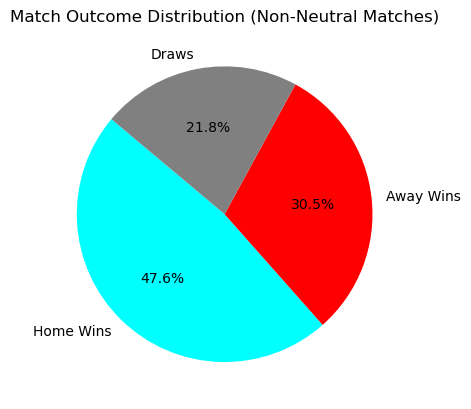

In [290]:
import pandas as pd

# Filter for non-neutral matches
non_neutral_matches = df[df['neutral'] == False]

home_team_wins_count = (non_neutral_matches['home_score'] > non_neutral_matches['away_score']).sum()
away_team_wins_count = (non_neutral_matches['away_score'] > non_neutral_matches['home_score']).sum()
draws = non_neutral_matches.shape[0] - home_team_wins_count - away_team_wins_count

print(f"Number of home team wins : {home_team_wins_count}")
print(f"Number of away team wins : {away_team_wins_count}")
print(f"Number of draws : {draws}")

total_matches = non_neutral_matches.shape[0]

home_win_rate = (home_team_wins_count / total_matches) * 100
away_win_rate = (away_team_wins_count / total_matches) * 100
draw_rate = (draws / total_matches) * 100
import matplotlib.pyplot as plt

labels = ['Home Wins', 'Away Wins', 'Draws']
counts = [home_team_wins_count, away_team_wins_count, draws]
colors = ['cyan', 'red', 'gray']

plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Match Outcome Distribution (Non-Neutral Matches)')
plt.show()



Number of Friendly matches: 5037
Number of Other Tournament matches: 7841
Total goals in Friendlies: 15724
Total goals in Other Tournaments: 22872
Average goals per match in Friendlies: 3.12
Average goals per match in Other Tournaments: 2.92


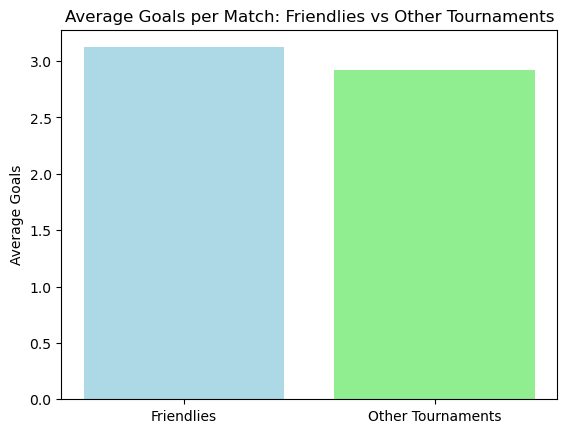

In [292]:
import pandas as pd


friendlies = df[df['tournament'] == 'Friendly']

other_tournaments = df[df['tournament'] != 'Friendly']

friendlies_goals = friendlies['home_score'].sum() + friendlies['away_score'].sum()

other_tournaments_goals = other_tournaments['home_score'].sum() + other_tournaments['away_score'].sum()

friendlies_count = friendlies.shape[0]  # Number of friendlies
other_tournaments_count = other_tournaments.shape[0]  # Number of other tournaments

average_goals_friendlies = friendlies_goals / friendlies_count if friendlies_count > 0 else 0
average_goals_other_tournaments = other_tournaments_goals / other_tournaments_count if other_tournaments_count > 0 else 0

print(f"Number of Friendly matches: {friendlies_count}")
print(f"Number of Other Tournament matches: {other_tournaments_count}")
print(f"Total goals in Friendlies: {friendlies_goals}")
print(f"Total goals in Other Tournaments: {other_tournaments_goals}")
print(f"Average goals per match in Friendlies: {average_goals_friendlies:.2f}")
print(f"Average goals per match in Other Tournaments: {average_goals_other_tournaments:.2f}")

categories = ['Friendlies', 'Other Tournaments']
averages = [average_goals_friendlies, average_goals_other_tournaments]

plt.bar(categories, averages, color=['lightblue', 'lightgreen'])
plt.title('Average Goals per Match: Friendlies vs Other Tournaments')
plt.ylabel('Average Goals')
plt.show()


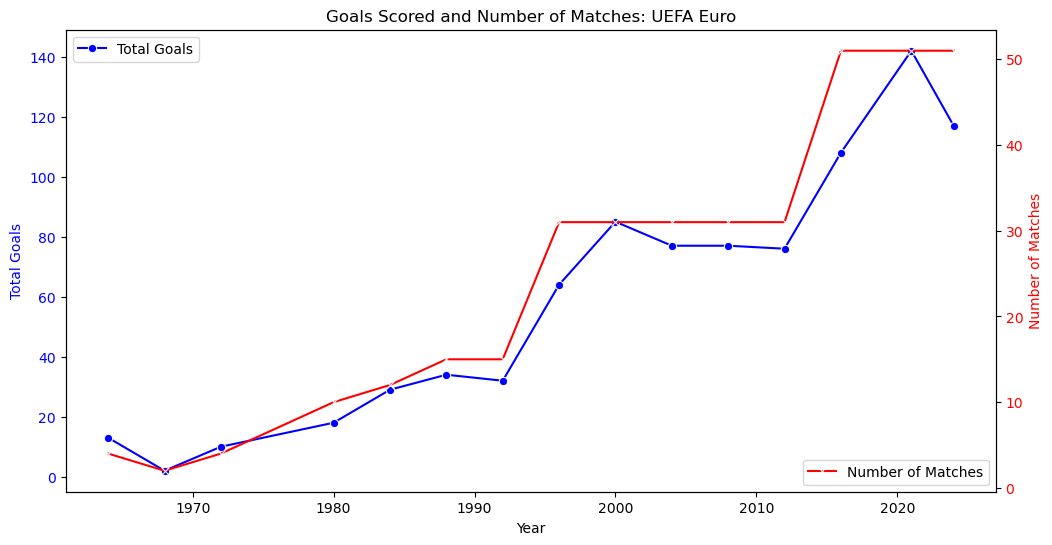

In [294]:
df['year'] = pd.to_datetime(df['date']).dt.year

Tourns = ['UEFA Euro']

filtered_df = df[df['tournament'].isin(Tourns)]

goals_by_year = filtered_df.groupby(['year', 'tournament'])[['home_score', 'away_score']].sum()
goals_by_year['total_goals'] = goals_by_year.sum(axis=1)

matches_by_year = filtered_df.groupby('year').size().reset_index(name='num_matches')

goals_and_matches_by_year = pd.merge(goals_by_year.reset_index(), matches_by_year, on='year')

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=goals_and_matches_by_year, x='year', y='total_goals', ax=ax1, color='blue', label='Total Goals', marker='o')
ax1.set_ylabel('Total Goals', color='blue')
ax1.set_xlabel('Year')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
sns.lineplot(data=goals_and_matches_by_year, x='year', y='num_matches', ax=ax2, color='red', label='Number of Matches', marker='x')
ax2.set_ylabel('Number of Matches', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Goals Scored and Number of Matches: UEFA Euro')
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.show()
